In [1]:
import sys
import os
import xarray
import openpyxl
import contextily as cx 
import yaml
import numpy as np
import pandas
import pathlib
import time
from datetime import date
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
# load functions from my scripts file "ssm_utils"
from ssm_utils import get_nearest_node, reshape_fvcom, calc_fvcom_stat, extract_fvcom_level

In [6]:
case="whidbey"
noncompliance=-0.25 
human_allowance=-0.2 
model_var="DOXG" 
run_file = f"/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/{case}/DOXG/wqm_baseline/wc/daily_min_DOXG_wc.nc"
with open(f'../etc/SSM_config_{case}.yaml', 'r') as file:
        ssm = yaml.safe_load(file)
        # get shapefile path    
        shp = ssm['paths']['shapefile']

In [3]:
#model_var="DOXG"
plt.rc('axes', titlesize=16)     # fontsize of the axes title

# Define dimension sizes and load shapefile
gdf = gpd.read_file(shp)
gdf = gdf.rename(columns={'region_inf':'Regions'})
regions = gdf[['node_id','Regions']].groupby(
    'Regions').count().index.to_list()
regions.remove('Other')
print(regions)

# Pull directory name from run_file path
run_type = run_file.split('/')[-3]
# Load minimum DO results from scenario
MinDO_full={}
MinDO={}
try: 
    with xarray.open_dataset(run_file) as ds:
        print([*ds])
        MinDO_full[run_type]=ds[f'{model_var}_daily_min_wc']
        # Sub-sample nodes (from 16012 nodes to 7494)
        MinDO[run_type]=MinDO_full[run_type][:,:,gdf['node_id']-1]
        print(MinDO[run_type].shape)
except FileNotFoundError:
    print(f'File Not Found: {run_file}')

['Hood', 'Main', 'SJF_Admiralty', 'SOG_Bellingham', 'South_Sound', 'Whidbey']
['DOXG_daily_min_wc']
(361, 10, 16012)


In [8]:
# Load minimum DO results from reference case
# Define reference run
reference = ssm['run_information']['reference']
base_dir = '/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/'
reference_file = f'{base_dir}/data/{case}/DOXG/{reference}/wc/daily_min_DOXG_wc.nc'
with xarray.open_dataset(reference_file) as ds:
    MinDO_full[reference]=ds[f'{model_var}_daily_min_wc']
    # Sub-sample nodes (from 16012 nodes to 7494)
    MinDO[reference]=MinDO_full[reference][:,:,gdf['node_id']-1]

# Get number of days and nodes
[ndays,nlevels,nnodes]=MinDO[run_type].shape
# Convert DO_standard to 3D array (time, depth, nodes) for Part B noncompliance calc
DO_std = np.tile(gdf.DO_std,(ndays,nlevels,1))
unmasked = np.tile(gdf.included_i, (ndays,nlevels,1))

# Initialize dictionaries
DO_diff_lt_0p2={} # Boolean where DO<threshold
DO_diff_lt_0p2_wc = {} # Boolean True where noncompliant at any level

# Calculate noncompliance
print(f'Calculating difference for {run_type}')
# Create array of Dissolved Oxygen threshold values 
DO_diff = MinDO[run_type] - MinDO[reference]
# Boolean where DO_diff < -0.2 (or noncompliance value)
DO_diff_lt_0p2[run_type] = (
    (DO_diff<=noncompliance) &   #361x4144 (nodes x time) or 361x10x4144
    (MinDO[reference] < DO_std + human_allowance)&
    (unmasked==1)
)


Calculating difference for wqm_baseline


In [9]:
# Take max over depth level to flag node as noncompliant if noncompliant anywhere in 
# water column
DO_diff_lt_0p2_wc[run_type]=DO_diff_lt_0p2[run_type].max(
    axis=1, initial=0)
# # Initialize dictionaries
DO_diff_lt_0p2={} # Boolean where DO<threshold
area_lt_0p2={} # 3D matrix of [0,1] where cells [are not, are] noncompliant
area_lt_0p2_TS={} # Time series of the above summed over depth and nodes

# Calculate noncompliance
# Create array of Dissolved Oxygen threshold values 
DO_diff = MinDO[run_type] - MinDO[reference]


In [21]:
# Boolean where DO_diff < -0.2 (or noncompliance value)
#361x4144 (nodes x time) or 361x10x4144
DO_diff_lt_0p2[run_type] = DO_diff<=noncompliance 
# element-wise multiplication of two 361x10x4144 arrays
area = np.asarray(gdf.Area_m2)
area2D = np.repeat(area[np.newaxis, :], 361, axis=0)
area_lt_0p2[run_type]=np.multiply(area2D, DO_diff_lt_0p2[run_type].max(axis=1))
area_lt_0p2[run_type].shape

(361, 16012)

In [24]:
area_lt_0p2_TS[run_type]=np.multiply(area2D, DO_diff_lt_0p2[run_type].max(axis=1))
# percent of region's volume that is noncompliant
total_area_noncompliant_byRegion={}
total_area_noncompliant_byRegion[run_type]={}
for region in regions: 
    idx = ((gdf['Regions']==region) &
            (gdf['included_i']==1))
    RegionArea = area[
        (gdf['Regions']==region) &
        (gdf['included_i']==1)
    ].sum()

    # time series of noncompliant volume in regions for each day  
    total_area_noncompliant_byRegion[run_type][region] = area_lt_0p2_TS[run_type][:,idx].sum(axis=1)

# repeat the above for the entire domain
idx = (gdf['included_i']==1)
RegionArea = area[
    (gdf['included_i']==1)
].sum()
# time series of noncompliant volume in regions for each day  
total_area_noncompliant_ALL = area_lt_0p2[run_type][:,idx].sum(
                axis=1)

# Convert to dataframe and organize information
TotalAreaNoncompliant_df = pandas.DataFrame(total_area_noncompliant_byRegion[run_type])

<AxesSubplot:>

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


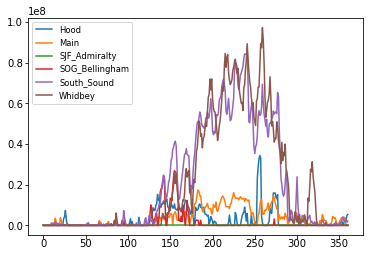

In [27]:
TotalAreaNoncompliant_df.plot()

# Volume noncompliance

In [34]:
volume_file = "whidbey_baseline_wc_noncompliant_m0p25_TS_byRegion.xlsx"
input_dir = pathlib.Path("/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/whidbey/spreadsheets")
vnc=pandas.read_excel(input_dir/volume_file).set_index("Unnamed: 0")

<AxesSubplot:xlabel='Unnamed: 0'>

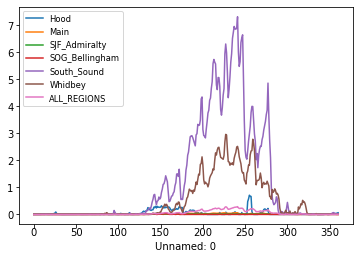

In [35]:
vnc.plot()

# Calculate average depth of different regions

In [40]:
depth=gdf.depth
MeanDepth={}
for region in regions: 
    idx = ((gdf['Regions']==region) &
            (gdf['included_i']==1))
    MeanDepth[region] = depth[
        (gdf['Regions']==region) &
        (gdf['included_i']==1)
    ].mean()*1000

In [43]:
MeanDepth_df = pandas.DataFrame(MeanDepth,index=["depth"])

<AxesSubplot:>

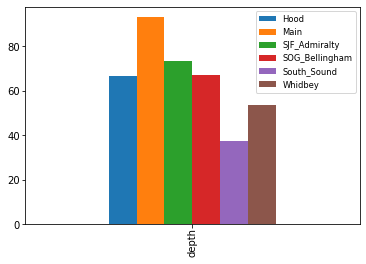

In [45]:
MeanDepth_df.plot(kind="bar")